### Imports

In [ ]:
from qbo import QBO
from qmc import QMC
import numpy as np
import pandas as pd
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from lstnet import LSTNet

import yfinance as yf
import seaborn as sns

### Download Data

In [2]:
data = yf.download("JPY=X", start="2022-01-01", end="2025-01-01")
historical_data = pd.DataFrame(data)
historical_data.to_csv("data/usdjpy.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
historical_data.head()

Price,Close,High,Low,Open,Volume
Ticker,JPY=X,JPY=X,JPY=X,JPY=X,JPY=X
Date,,,,,
2022-01-03,115.141998,115.360001,114.973999,115.136002,0
2022-01-04,115.328003,116.339996,115.299004,115.316002,0
2022-01-05,116.174004,116.235001,115.626999,116.165001,0
2022-01-06,116.127998,116.179001,115.653999,116.128998,0
2022-01-07,115.864998,116.029999,115.591003,115.870003,0


Text(0.5, 1.0, 'USD/JPY Close')

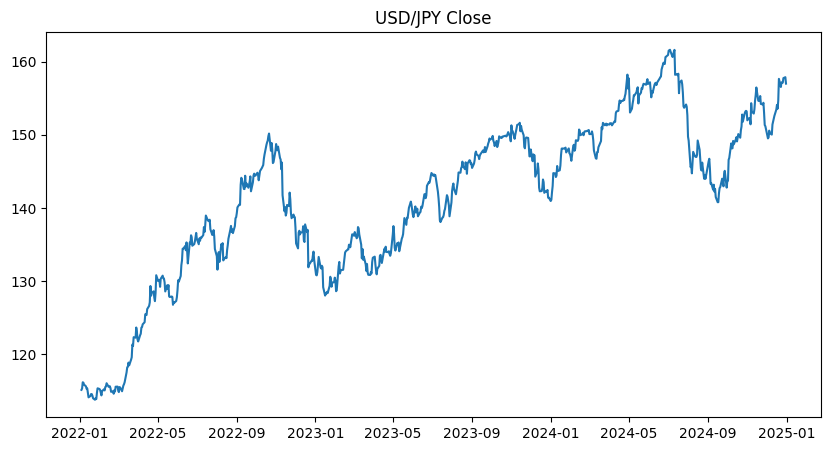

In [4]:
# Display closing price
# This is non-linear, non-stationary. Models WILL struggle to define relationships. Future datapoints could make gradients unstable
f = plt.figure(figsize=(10, 5))
plt.plot(historical_data["Close"].index, historical_data["Close"])
plt.title("USD/JPY Close")

Text(0.5, 1.0, 'USD/JPY Log-Return')

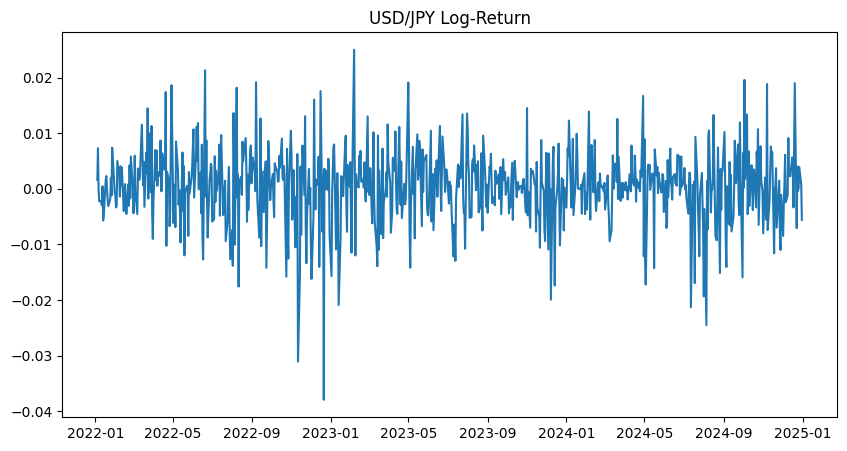

In [5]:
# Here, we compute the log returns. This allows the data to now be stationary
# This also creates a form of normalization, stabilizing gradients for future inputs
f = plt.figure(figsize=(10, 5))
y = np.log(historical_data["Close"].to_numpy()).squeeze()
y_delta = y[1:] - y[:-1]

plt.plot(historical_data["Close"].index[1:], y_delta)
plt.title("USD/JPY Log-Return")

### Experiment Config

### Train and Test Datasets

In [25]:
class USDJPY(Dataset):
    def __init__(self, data, period):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.period = period
    
    def __len__(self):
        return len(self.data) - self.period

    def __getitem__(self, index):
        x = self.data[index: index + self.period]
        y = self.data[index + self.period]
        return x.unsqueeze(1), y

In [ ]:
split = 0.7
period = 10
log_data = np.log(historical_data["Close"].to_numpy())
log_return_data = y[1:] - y[:-1]
train_log_return = log_return_data[:-100]
test_log_return = log_return_data[-(100 + period):] # use first period as ramp up

train_dataset = USDJPY(train_log_return, period=period)
test_dataset = USDJPY(test_log_return, period=period)

In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
for item, item2 in train_loader:
    print(item.shape)

torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([32, 10, 1])
torch.Size([31, 10, 1])


### MODEL DEBUG

In [29]:
def train(loader: DataLoader, model: torch.nn.Module, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for sequences, targets in loader:
        optimizer.zero_grad()
        preds = model(sequences)
        preds = torch.squeeze(preds)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * sequences.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

In [30]:
def test(loader: DataLoader, model: torch.nn.Module):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, targets in loader:
            preds = model(sequences)
            preds = torch.squeeze(preds)
            loss = torch.nn.functional.mse_loss(preds, targets)
            total_loss += loss.item() * sequences.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

In [31]:
def test_graph(loader: DataLoader, model: torch.nn.Module):
    model.eval()
    preds = []
    ground_truth = []
    with torch.no_grad():
        for sequences, targets in loader:
            pred = model(sequences)
            pred = torch.squeeze(pred)
            preds.extend(pred.numpy())
            ground_truth.extend(targets.numpy())
    
    return np.asarray(preds), np.asarray(ground_truth)

In [32]:
def test_series(ground_truth, period, model: torch.nn.Module):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(len(ground_truth) - period):
            x = torch.tensor(ground_truth[i: i + period], dtype=torch.float32)
            x = x[torch.newaxis, :, torch.newaxis]
            pred = model(x)
            pred = torch.squeeze(pred)
            preds.append(pred.numpy())
    return np.asarray(preds)

In [33]:
model = LSTNet(period=period, num_features=1, rnn_dim=64, cnn_dim=64, skip_dim=32)

In [34]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-6)

In [35]:
# VARY EPOCHS, PERIOD, BATCH
epochs = 1000
loss_history = []
for epoch in range(epochs):
    loss = train(train_loader, model, optim, loss_fn)
    loss_history.append(loss)
    if epoch % 5 == 0:
        print("Epoch:", epoch)
        print(f"Loss: {loss:.6f}")

Epoch: 0
Loss: 0.099583
Epoch: 5
Loss: 0.093662
Epoch: 10
Loss: 0.090591
Epoch: 15
Loss: 0.086539
Epoch: 20
Loss: 0.082137
Epoch: 25
Loss: 0.077178
Epoch: 30
Loss: 0.074921
Epoch: 35
Loss: 0.072136
Epoch: 40
Loss: 0.068899
Epoch: 45
Loss: 0.064158
Epoch: 50
Loss: 0.060241
Epoch: 55
Loss: 0.057581
Epoch: 60
Loss: 0.055262
Epoch: 65
Loss: 0.052472
Epoch: 70
Loss: 0.050582
Epoch: 75
Loss: 0.046651
Epoch: 80
Loss: 0.044575
Epoch: 85
Loss: 0.042333
Epoch: 90
Loss: 0.040079
Epoch: 95
Loss: 0.037400
Epoch: 100
Loss: 0.035341
Epoch: 105
Loss: 0.033145
Epoch: 110
Loss: 0.030442
Epoch: 115
Loss: 0.028529
Epoch: 120
Loss: 0.027954
Epoch: 125
Loss: 0.025658
Epoch: 130
Loss: 0.024099
Epoch: 135
Loss: 0.022168
Epoch: 140
Loss: 0.020786
Epoch: 145
Loss: 0.018802
Epoch: 150
Loss: 0.018001
Epoch: 155
Loss: 0.016695
Epoch: 160
Loss: 0.015930
Epoch: 165
Loss: 0.014645
Epoch: 170
Loss: 0.013160
Epoch: 175
Loss: 0.012393
Epoch: 180
Loss: 0.011019
Epoch: 185
Loss: 0.011214
Epoch: 190
Loss: 0.008998
Epoch: 1

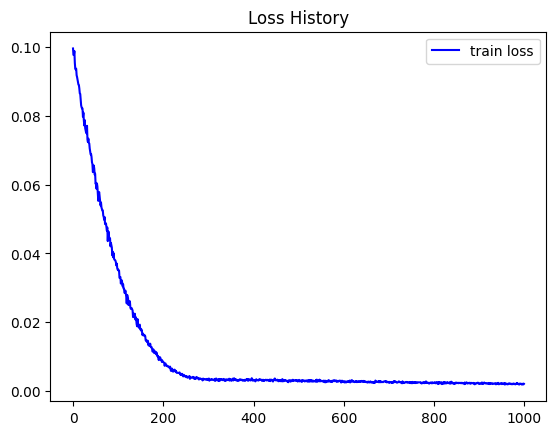

In [36]:
plt.plot(loss_history, color="blue", label="train loss")
plt.title("Loss History")
plt.legend()

In [40]:
out_sample_preds = test_series(test_log_return, period, model)
print(out_sample_preds.shape)
print(test_log_return.shape)

(100,)
(110,)


Text(0.5, 1.0, 'Out of Sample USD/JPY Log-Return')

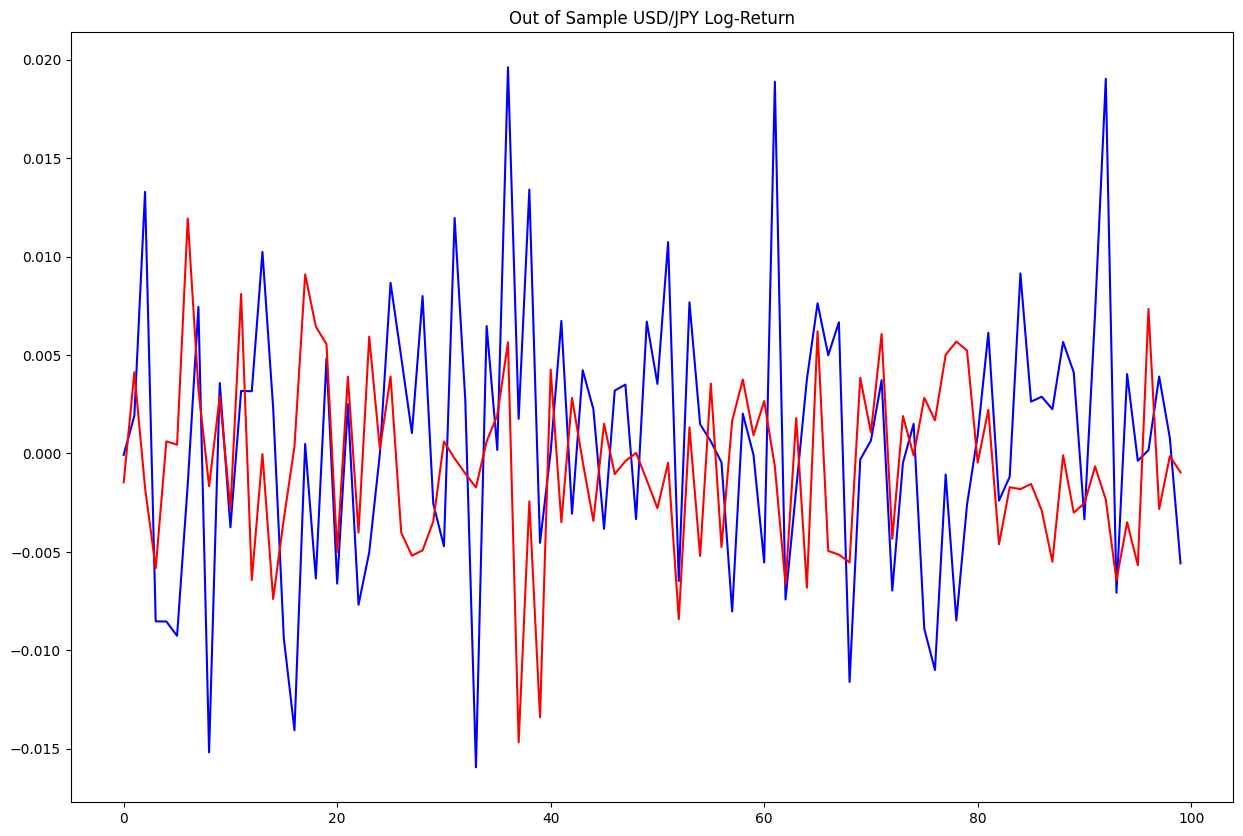

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(test_log_return) - period), test_log_return[period:], color="blue")
plt.plot(np.arange(len(out_sample_preds)), out_sample_preds, color="red")
plt.title("Out of Sample USD/JPY Log-Return")

In [43]:
in_sample_preds, in_sample_gt = test_graph(train_loader, model)
out_sample_preds, out_sample_gt = test_graph(test_loader, model)

Text(0.5, 1.0, 'In Sample USD/JPY Log-Return')

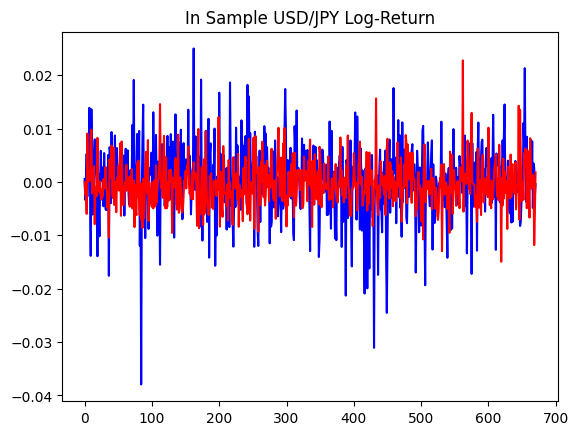

In [44]:
plt.plot(np.arange(len(in_sample_gt)), in_sample_gt, color="blue")
plt.plot(np.arange(len(in_sample_preds)), in_sample_preds * 1, color="red")
plt.title("In Sample USD/JPY Log-Return")

Text(0.5, 1.0, 'Out of Sample USD/JPY Log-Return')

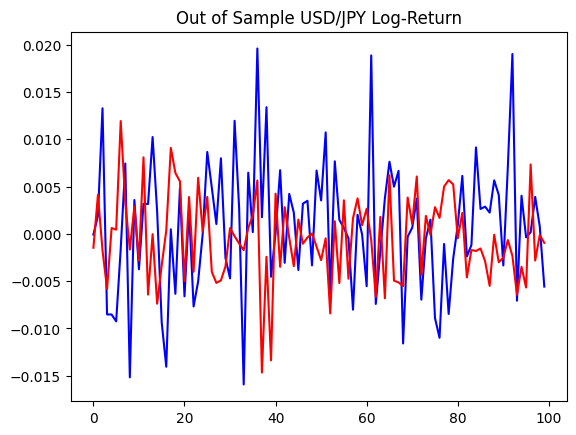

In [45]:
plt.plot(np.arange(len(out_sample_gt)), out_sample_gt, color="blue")
plt.plot(np.arange(len(out_sample_preds)), out_sample_preds * 1, color="red")
plt.title("Out of Sample USD/JPY Log-Return")